<a href="https://colab.research.google.com/github/sman-1010/SENTIMENT-DETECTION-FROM-FACIAL-EXPRESSIONS/blob/main/facial_expression_large_dataset_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 90% 108M/121M [00:01<00:00, 108MB/s] 
100% 121M/121M [00:01<00:00, 106MB/s]


In [ ]:
! unzip face-expression-recognition-dataset.zip

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#from google.colab import drive

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()


def load_data(data_path):
    """
    Load the dataset to the memory.
  
    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts
   
    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)
        
            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 6)
    #print(img_data_list[0].shape)

    data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    #print("\nTotal number of uploaded data: ", img_data_list.shape[0],
    #      ", with data shape", img_data_list.shape[1], img_data_list.shape[2],img_data_list.shape[3]))

    return img_data_list, labels

[INFO] Dataset Loading...

Loading : 4938 images of category sad
Loading : 3205 images of category surprise
Loading : 3993 images of category angry
Loading : 436 images of category disgust
Loading : 7164 images of category happy
Loading : 4103 images of category fear


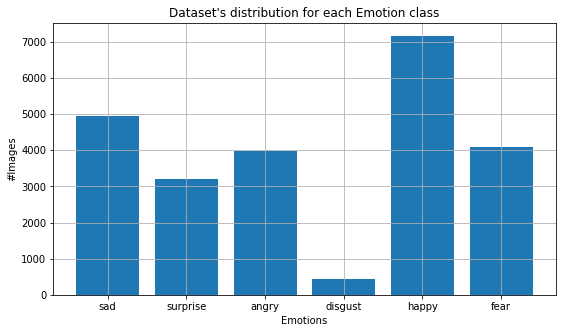

In [ ]:
# data_path_ck = "/home/i4/Downloads/other_dataset_facial/train"
data_path_ck = "/content/images/images/train"
data, labels = load_data(data_path_ck)

In [ ]:
labels[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
class_weights = {0: 1,
 1: 3,
 2: 1,
 3: 1,
 4: 1,
 5: 1}

In [ ]:
!rm -r /content/images/images/train/neutral

In [ ]:
# Split the dataset into two subsets (70%-30%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(np.array(data), labels, test_size=0.3, shuffle=True, random_state=3)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

# The second subset will be split into validation and test set (50%-50%).
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=3)

print(f"X_valid has shape: {X_valid.shape}")
print(f"y_valid has shape: {y_valid.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_valid + X_test = {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (16687, 48, 48, 3)
y_train has shape: (16687, 6)

X_valid has shape: (3576, 48, 48, 3)
y_valid has shape: (3576, 6)

X_test has shape: (3576, 48, 48, 3)
y_test has shape: (3576, 6)

X_train + X_valid + X_test = 23839 samples in total


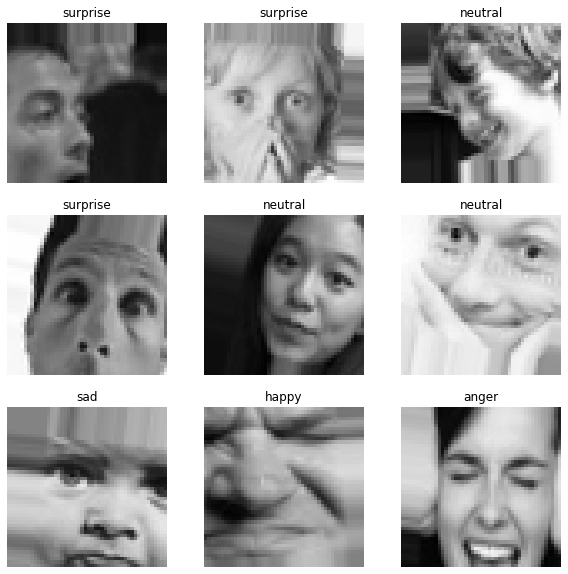

In [ ]:
# Map the emotion-categories
# mapping = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'sadness', 5:'surprise'}
mapping = {0:'anger', 1:'fear', 2:'happy', 3:'neutral', 4:'sad', 5:'surprise'}
#mapping = {0:'anger', 1:'fear', 2:'happy', 3:'sadness', 4:'surprise'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              width_shift_range=0.2,
                              #brightness_range=(.6, 1.2),
                              shear_range=.15,
                              height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10)),
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 9:
        break

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label)])
    plt.axis("off")

In [ ]:
def build_model():
    """
    Create the new model.
  
    This function loads a pre-trained EfficientNetB0 model on Imagenet,
    adds an Input layer at the beggining, and 3 more layers at the end
    (i.e GlobalAveragePooling2D, Dropout, Dense).

    Args:
        No value
   
    Returns:
        model (tensorflow.python.keras.engine.functional.Functional): The compiled model
    """
    
    inputs = Input(shape=(48, 48, 3))
    base_model = ResNet50(include_top=False, weights="imagenet",
                                 input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.2, name="top_dropout")(x)
    outputs = Dense(128, activation='relu')(x)
    outputs = Dense(64, activation='relu')(outputs)
    outputs = Dense(6, activation='softmax')(outputs)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Create an object of the model
model = build_model()

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
EPOCHS = 100
batch_size = 128
#filepath = "/content/drive/MyDrive/Data/tmp/checkpoint/weights.best.hdf5"
filepath = "./home/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS, callbacks=callbacks,class_weight=class_weights)

[INFO] training network for 100 epochs...

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 1.5795 - accuracy: 0.4144
Epoch 1: val_accuracy improved from -inf to 0.40101, saving model to ./home/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f
INFO:tensorflow:Assets written to: ./home/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f/assets
130/130 [==============================] - 46s 313ms/step - loss: 1.5795 - accuracy: 0.4144 - val_loss: 2.1115 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 1.3299 - accuracy: 0.5111
Epoch 2: val_accuracy improved from 0.40101 to 0.41527, saving model to ./home/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f
INFO:tensorflow:Assets written to: ./home/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f/assets
130/130 [==============================] - 40s 304ms/step - loss: 1.3299 - accuracy: 0.5111 - val_loss: 1.6536 - val_accuracy: 0.4153 - lr: 0.0010
Epoch 3/100
130/

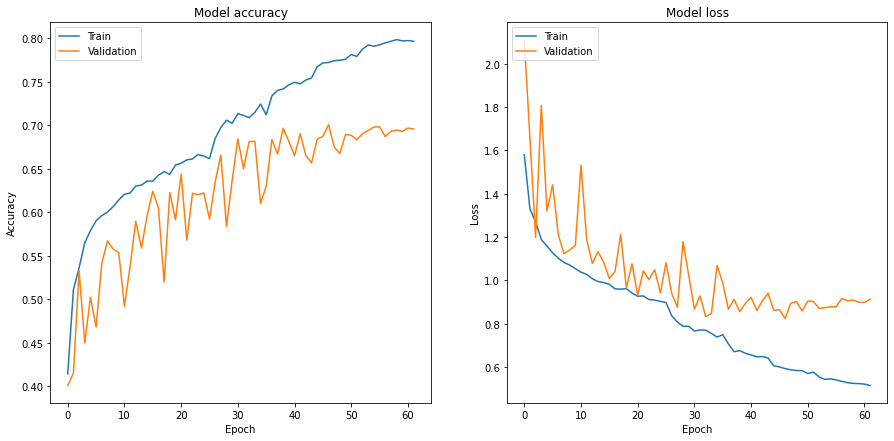

In [ ]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# model.load_weights('/content/drive/MyDrive/CENG562_Dataset/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f')

In [ ]:
def show_confusion_matrix(X_test, y_test):
    """
    Show the confusion matrix of the unseen data.
  
    This function takes a fraction of the dataset that has not seen yet and
    tries to categorize each image into one of the 6 classes. The results are
    represented through a confusion matrix.

    Args:
        X_test (numpy.ndarray): unseen images
        y_test (numpy.ndarray): their corresponding labels
   
    Returns:
        No value
    """

    # Predict the test set (the system hasn't seen it yet)
    predictions = model.predict(X_test, verbose=0)
    
    y_classes =  np.argmax(predictions, axis=1)
    actual_classes =  np.argmax(y_test, axis=1)

    pred_labels = [mapping[element] for element in y_classes]
    actual_labels = [mapping[element] for element in actual_classes]

    # Create a dictionary
    data = {'y_Actual':    actual_labels,
            'y_Predicted': pred_labels}

    # Create a dataframe
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    # Calculate model's accuracy
    correct_predictions = sum(map(lambda x, y: x == y, pred_labels, actual_labels))
    all_samples = len(y_test)
    print(f"Final accuracy: {correct_predictions/all_samples * 100:.2f}%")

    # Plot the confusion matrix
    _, ax = plt.subplots(figsize=(10,8)) 
    sn.heatmap(confusion_matrix, annot = True, ax=ax)
    plt.show()

In [ ]:
#evaluate the model
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
28/28 [==============================] - 2s 58ms/step - loss: 0.8470 - accuracy: 0.6999
test loss, test acc: [0.8469976186752319, 0.6999440789222717]


Final accuracy: 69.99%


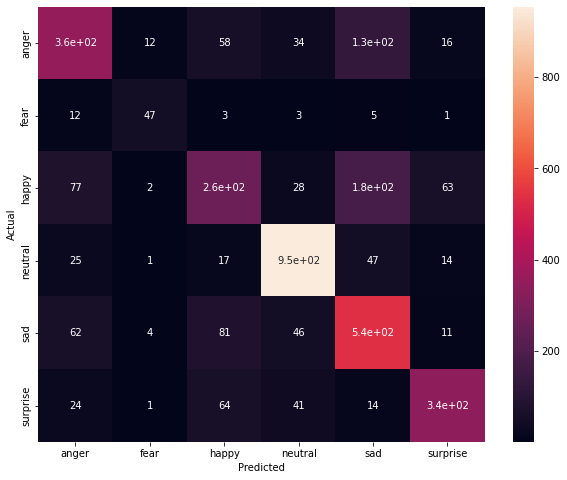

In [ ]:
show_confusion_matrix(X_test, y_test)

In [ ]:
model.save('WO_disgust_WEIHGHTS_none.h5')

In [ ]:
!pwd

/content
